# Visualize cell-cell edge-edge distances

This notebook ensures cells with 0 distance between them are indeed touching and created visualizations for the figures.

In [1]:
import numpy as np
import cv2
import tifffile
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import math
import seaborn as sns
from skimage import data, segmentation, util, measure
from skimage.segmentation import expand_labels
from numpy import ma 
from matplotlib import ticker, cm 
import scipy.spatial.distance

In [2]:
# create dictionary of directories for each patient's normalized images
img_dirs = {'P51':'/data/Zhaolab/1_AMLCosMx/Final_scripts/1_Normalization/0_NormalizedImg/P51_R1158_S1_Normalized/', 
            'P52':'/data/Zhaolab/1_AMLCosMx/Final_scripts/1_Normalization/0_NormalizedImg/P52_R1149_S1_Normalized/', 
            'P53':'/data/Zhaolab/1_AMLCosMx/Final_scripts/1_Normalization/0_NormalizedImg/P53_R1149_S2_Normalized/', 
            'P56':'/data/Zhaolab/1_AMLCosMx/Final_scripts/1_Normalization/0_NormalizedImg/P56_R1158_S2_Normalized/', 
            'P57':'/data/Zhaolab/1_AMLCosMx/Final_scripts/1_Normalization/0_NormalizedImg/P57_R1158_S3_Normalized/', 
            'P58':'/data/Zhaolab/1_AMLCosMx/Final_scripts/1_Normalization/0_NormalizedImg/P58_R1149_S3_Normalized/'}

In [3]:
dist_dir = '/data/Zhaolab/1_AMLCosMx/Final_scripts/5_SpatialAnalysis/1_MeasureCellDists/cell-cell_distances/'

In [4]:
# create dictionary of patient names
name_dirs = {'p1':'P51', 'p2':'P52', 'p3':'P53', 'p4':'P56', 'p5':'P57', 'p6':'P58'}

## Summarize all FOVs cell-cell distances

In [5]:
patients = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6']

In [6]:
All_fovs = [] # create empty list to store DF objects for each FOV

for pt in patients:

    alt_pt_name = name_dirs[pt]

    # define masks location
    mask_loc = '/data/Zhaolab/1_AMLCosMx/Final_scripts/2_Segmentation/3_NucMemMerging/' + alt_pt_name + '_hybrid/labels_predicted_2_15_24/'
    
    # index through all FOVs
    # read in table of cell centroid locations
    centroid_dir = mask_loc + 'cell_centroids/'
    dirlist = os.listdir(centroid_dir)
    dirlist.sort()
    for item in dirlist:
        
        # get FOV number
        fov = item[34:36]
        
        # read in centroid table, add column specifying FOV number for each cell
        centroids = pd.read_csv(centroid_dir + item, index_col=0)
        centroids = centroids[['label', 'y', 'x']]
        centroids['FOV'] = fov
        
        # get IDs of all cells as list
        all_ids = centroids['label'].tolist()
        
        # set cell id as index
        one_fov = centroids.set_index('label')
        
        # convert centroid coordinates to numpy array
        twoD_array = one_fov[['y','x']].to_numpy()

        # calculate pairwise distances between all cell centroids
        dists = scipy.spatial.distance.pdist(twoD_array, metric='euclidean')
        dists_square = scipy.spatial.distance.squareform(dists, force='no', checks=True)
        np.fill_diagonal(dists_square, np.nan, wrap=False) # replace 0s with Nan in diagonal
        dists_square = pd.DataFrame(dists_square, index=all_ids, columns=all_ids) # convert to DF

        # add DF columns to store nearest neighbor ID and distance in pixels
        one_fov['centroid_neighbor'] = 0
        one_fov['centroid_neighbor_dist'] = 0
        for cell in all_ids:
            one_fov['centroid_neighbor'].loc[cell] = dists_square.loc[cell].idxmin()
            one_fov['centroid_neighbor_dist'].loc[cell] = dists_square.loc[cell].min()
            
        # read in edge-edge distances computed between all cells
        min_dists = pd.read_csv(dist_dir + name_dirs[pt] + '_FOV' + fov + '_cell_contacts.csv', index_col=0)
        min_dists.columns = min_dists.columns.astype(int)

        # filter to only relevant cells
        min_dists = min_dists.filter(items=all_ids, axis=0)
        min_dists = min_dists.filter(items=all_ids, axis=1)

        one_fov['edge_neighbor'] = 0
        one_fov['edge_neighbor_dist'] = 0
        one_fov['num_touching'] = 0

        for cell in all_ids:
            one_fov['edge_neighbor_dist'].loc[cell] = min_dists.loc[cell].min()
            nearest_cells = min_dists.loc[cell][min_dists.loc[cell] == min_dists.loc[cell].min()].index.tolist()

            if min_dists.loc[cell].min() == 0:
                one_fov['num_touching'].loc[cell] = len(nearest_cells)

            if one_fov['centroid_neighbor'].loc[cell] in nearest_cells:
                one_fov['edge_neighbor'].loc[cell] = one_fov['centroid_neighbor'].loc[cell]
            else:
                one_fov['edge_neighbor'].loc[cell] = nearest_cells[0]
                
        All_fovs.append(one_fov) # save each FOV DF in list
        

/tmp/ipykernel_3628461/834660860.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor'].loc[cell] = dists_square.loc[cell].idxmin()
/tmp/ipykernel_3628461/834660860.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor_dist'].loc[cell] = dists_square.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc

/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc[cell] = min_dists.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['num_touching'].loc[cell] = len(nearest_cells)
/tmp/ipykernel_3628461/834660860.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor'].loc[cell] = one_fov['centroid_nei

/tmp/ipykernel_3628461/834660860.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor'].loc[cell] = dists_square.loc[cell].idxmin()
/tmp/ipykernel_3628461/834660860.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor_dist'].loc[cell] = dists_square.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc

/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc[cell] = min_dists.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor'].loc[cell] = one_fov['centroid_neighbor'].loc[cell]
/tmp/ipykernel_3628461/834660860.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['num_touching'].loc[cell] = l

/tmp/ipykernel_3628461/834660860.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor'].loc[cell] = dists_square.loc[cell].idxmin()
/tmp/ipykernel_3628461/834660860.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor_dist'].loc[cell] = dists_square.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc

/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc[cell] = min_dists.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['num_touching'].loc[cell] = len(nearest_cells)
/tmp/ipykernel_3628461/834660860.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor'].loc[cell] = one_fov['centroid_nei

/tmp/ipykernel_3628461/834660860.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor'].loc[cell] = dists_square.loc[cell].idxmin()
/tmp/ipykernel_3628461/834660860.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor_dist'].loc[cell] = dists_square.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc

/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc[cell] = min_dists.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['num_touching'].loc[cell] = len(nearest_cells)
/tmp/ipykernel_3628461/834660860.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor'].loc[cell] = nearest_cells[0]
/tmp

/tmp/ipykernel_3628461/834660860.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor'].loc[cell] = dists_square.loc[cell].idxmin()
/tmp/ipykernel_3628461/834660860.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor_dist'].loc[cell] = dists_square.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc

/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc[cell] = min_dists.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['num_touching'].loc[cell] = len(nearest_cells)
/tmp/ipykernel_3628461/834660860.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor'].loc[cell] = one_fov['centroid_nei

/tmp/ipykernel_3628461/834660860.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor'].loc[cell] = dists_square.loc[cell].idxmin()
/tmp/ipykernel_3628461/834660860.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor_dist'].loc[cell] = dists_square.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc

/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc[cell] = min_dists.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['num_touching'].loc[cell] = len(nearest_cells)
/tmp/ipykernel_3628461/834660860.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor'].loc[cell] = one_fov['centroid_nei

/tmp/ipykernel_3628461/834660860.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor'].loc[cell] = dists_square.loc[cell].idxmin()
/tmp/ipykernel_3628461/834660860.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor_dist'].loc[cell] = dists_square.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc

/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc[cell] = min_dists.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['num_touching'].loc[cell] = len(nearest_cells)
/tmp/ipykernel_3628461/834660860.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor'].loc[cell] = one_fov['centroid_nei

/tmp/ipykernel_3628461/834660860.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor'].loc[cell] = dists_square.loc[cell].idxmin()
/tmp/ipykernel_3628461/834660860.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor_dist'].loc[cell] = dists_square.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc

/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc[cell] = min_dists.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor'].loc[cell] = one_fov['centroid_neighbor'].loc[cell]
/tmp/ipykernel_3628461/834660860.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['num_touching'].loc[cell] = l

/tmp/ipykernel_3628461/834660860.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor'].loc[cell] = dists_square.loc[cell].idxmin()
/tmp/ipykernel_3628461/834660860.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor_dist'].loc[cell] = dists_square.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc

/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc[cell] = min_dists.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['num_touching'].loc[cell] = len(nearest_cells)
/tmp/ipykernel_3628461/834660860.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor'].loc[cell] = one_fov['centroid_nei

/tmp/ipykernel_3628461/834660860.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor'].loc[cell] = dists_square.loc[cell].idxmin()
/tmp/ipykernel_3628461/834660860.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor_dist'].loc[cell] = dists_square.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc

/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc[cell] = min_dists.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['num_touching'].loc[cell] = len(nearest_cells)
/tmp/ipykernel_3628461/834660860.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor'].loc[cell] = one_fov['centroid_nei

/tmp/ipykernel_3628461/834660860.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor'].loc[cell] = dists_square.loc[cell].idxmin()
/tmp/ipykernel_3628461/834660860.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor_dist'].loc[cell] = dists_square.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc

/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc[cell] = min_dists.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor'].loc[cell] = one_fov['centroid_neighbor'].loc[cell]
/tmp/ipykernel_3628461/834660860.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor'].loc[cell] = 

/tmp/ipykernel_3628461/834660860.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor'].loc[cell] = dists_square.loc[cell].idxmin()
/tmp/ipykernel_3628461/834660860.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor_dist'].loc[cell] = dists_square.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc

/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc[cell] = min_dists.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor'].loc[cell] = one_fov['centroid_neighbor'].loc[cell]
/tmp/ipykernel_3628461/834660860.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['num_touching'].loc[cell] = l

/tmp/ipykernel_3628461/834660860.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor'].loc[cell] = dists_square.loc[cell].idxmin()
/tmp/ipykernel_3628461/834660860.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor_dist'].loc[cell] = dists_square.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc

/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc[cell] = min_dists.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['num_touching'].loc[cell] = len(nearest_cells)
/tmp/ipykernel_3628461/834660860.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor'].loc[cell] = one_fov['centroid_nei

/tmp/ipykernel_3628461/834660860.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor'].loc[cell] = dists_square.loc[cell].idxmin()
/tmp/ipykernel_3628461/834660860.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor_dist'].loc[cell] = dists_square.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc

/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc[cell] = min_dists.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['num_touching'].loc[cell] = len(nearest_cells)
/tmp/ipykernel_3628461/834660860.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor'].loc[cell] = one_fov['centroid_nei

/tmp/ipykernel_3628461/834660860.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor'].loc[cell] = dists_square.loc[cell].idxmin()
/tmp/ipykernel_3628461/834660860.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor_dist'].loc[cell] = dists_square.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc

/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc[cell] = min_dists.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['num_touching'].loc[cell] = len(nearest_cells)
/tmp/ipykernel_3628461/834660860.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor'].loc[cell] = one_fov['centroid_nei

/tmp/ipykernel_3628461/834660860.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor'].loc[cell] = dists_square.loc[cell].idxmin()
/tmp/ipykernel_3628461/834660860.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['centroid_neighbor_dist'].loc[cell] = dists_square.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc

/tmp/ipykernel_3628461/834660860.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor_dist'].loc[cell] = min_dists.loc[cell].min()
/tmp/ipykernel_3628461/834660860.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['num_touching'].loc[cell] = len(nearest_cells)
/tmp/ipykernel_3628461/834660860.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_fov['edge_neighbor'].loc[cell] = nearest_cells[0]
/tmp

In [7]:
# concatentate all FOVs in single DF
All_fovs_NN = pd.concat(All_fovs)
All_fovs_NN

,y,x,FOV,centroid_neighbor,centroid_neighbor_dist,edge_neighbor,edge_neighbor_dist,num_touching
label,,,,,,,,
1,15.766334,74.070875,01,2,43.711773,2,3.61,0
2,14.835116,117.772727,01,1273,43.545177,1273,0.00,1
3,20.265487,218.211898,01,1273,58.095437,1273,2.24,0
4,41.141279,962.670481,01,1275,31.742707,1275,0.00,2
5,16.085487,1059.072565,01,1276,76.697843,1275,38.00,0
...,...,...,...,...,...,...,...,...
7971,3640.771812,4117.850671,23,3274,30.202244,3274,0.00,2
7972,3641.122563,4992.493036,23,7909,55.953195,3248,13.34,0
7973,3642.707447,3546.191489,23,3278,38.458542,3278,0.00,1


In [8]:
import matplotlib as mpl
mpl.rc('font',family='Arial')

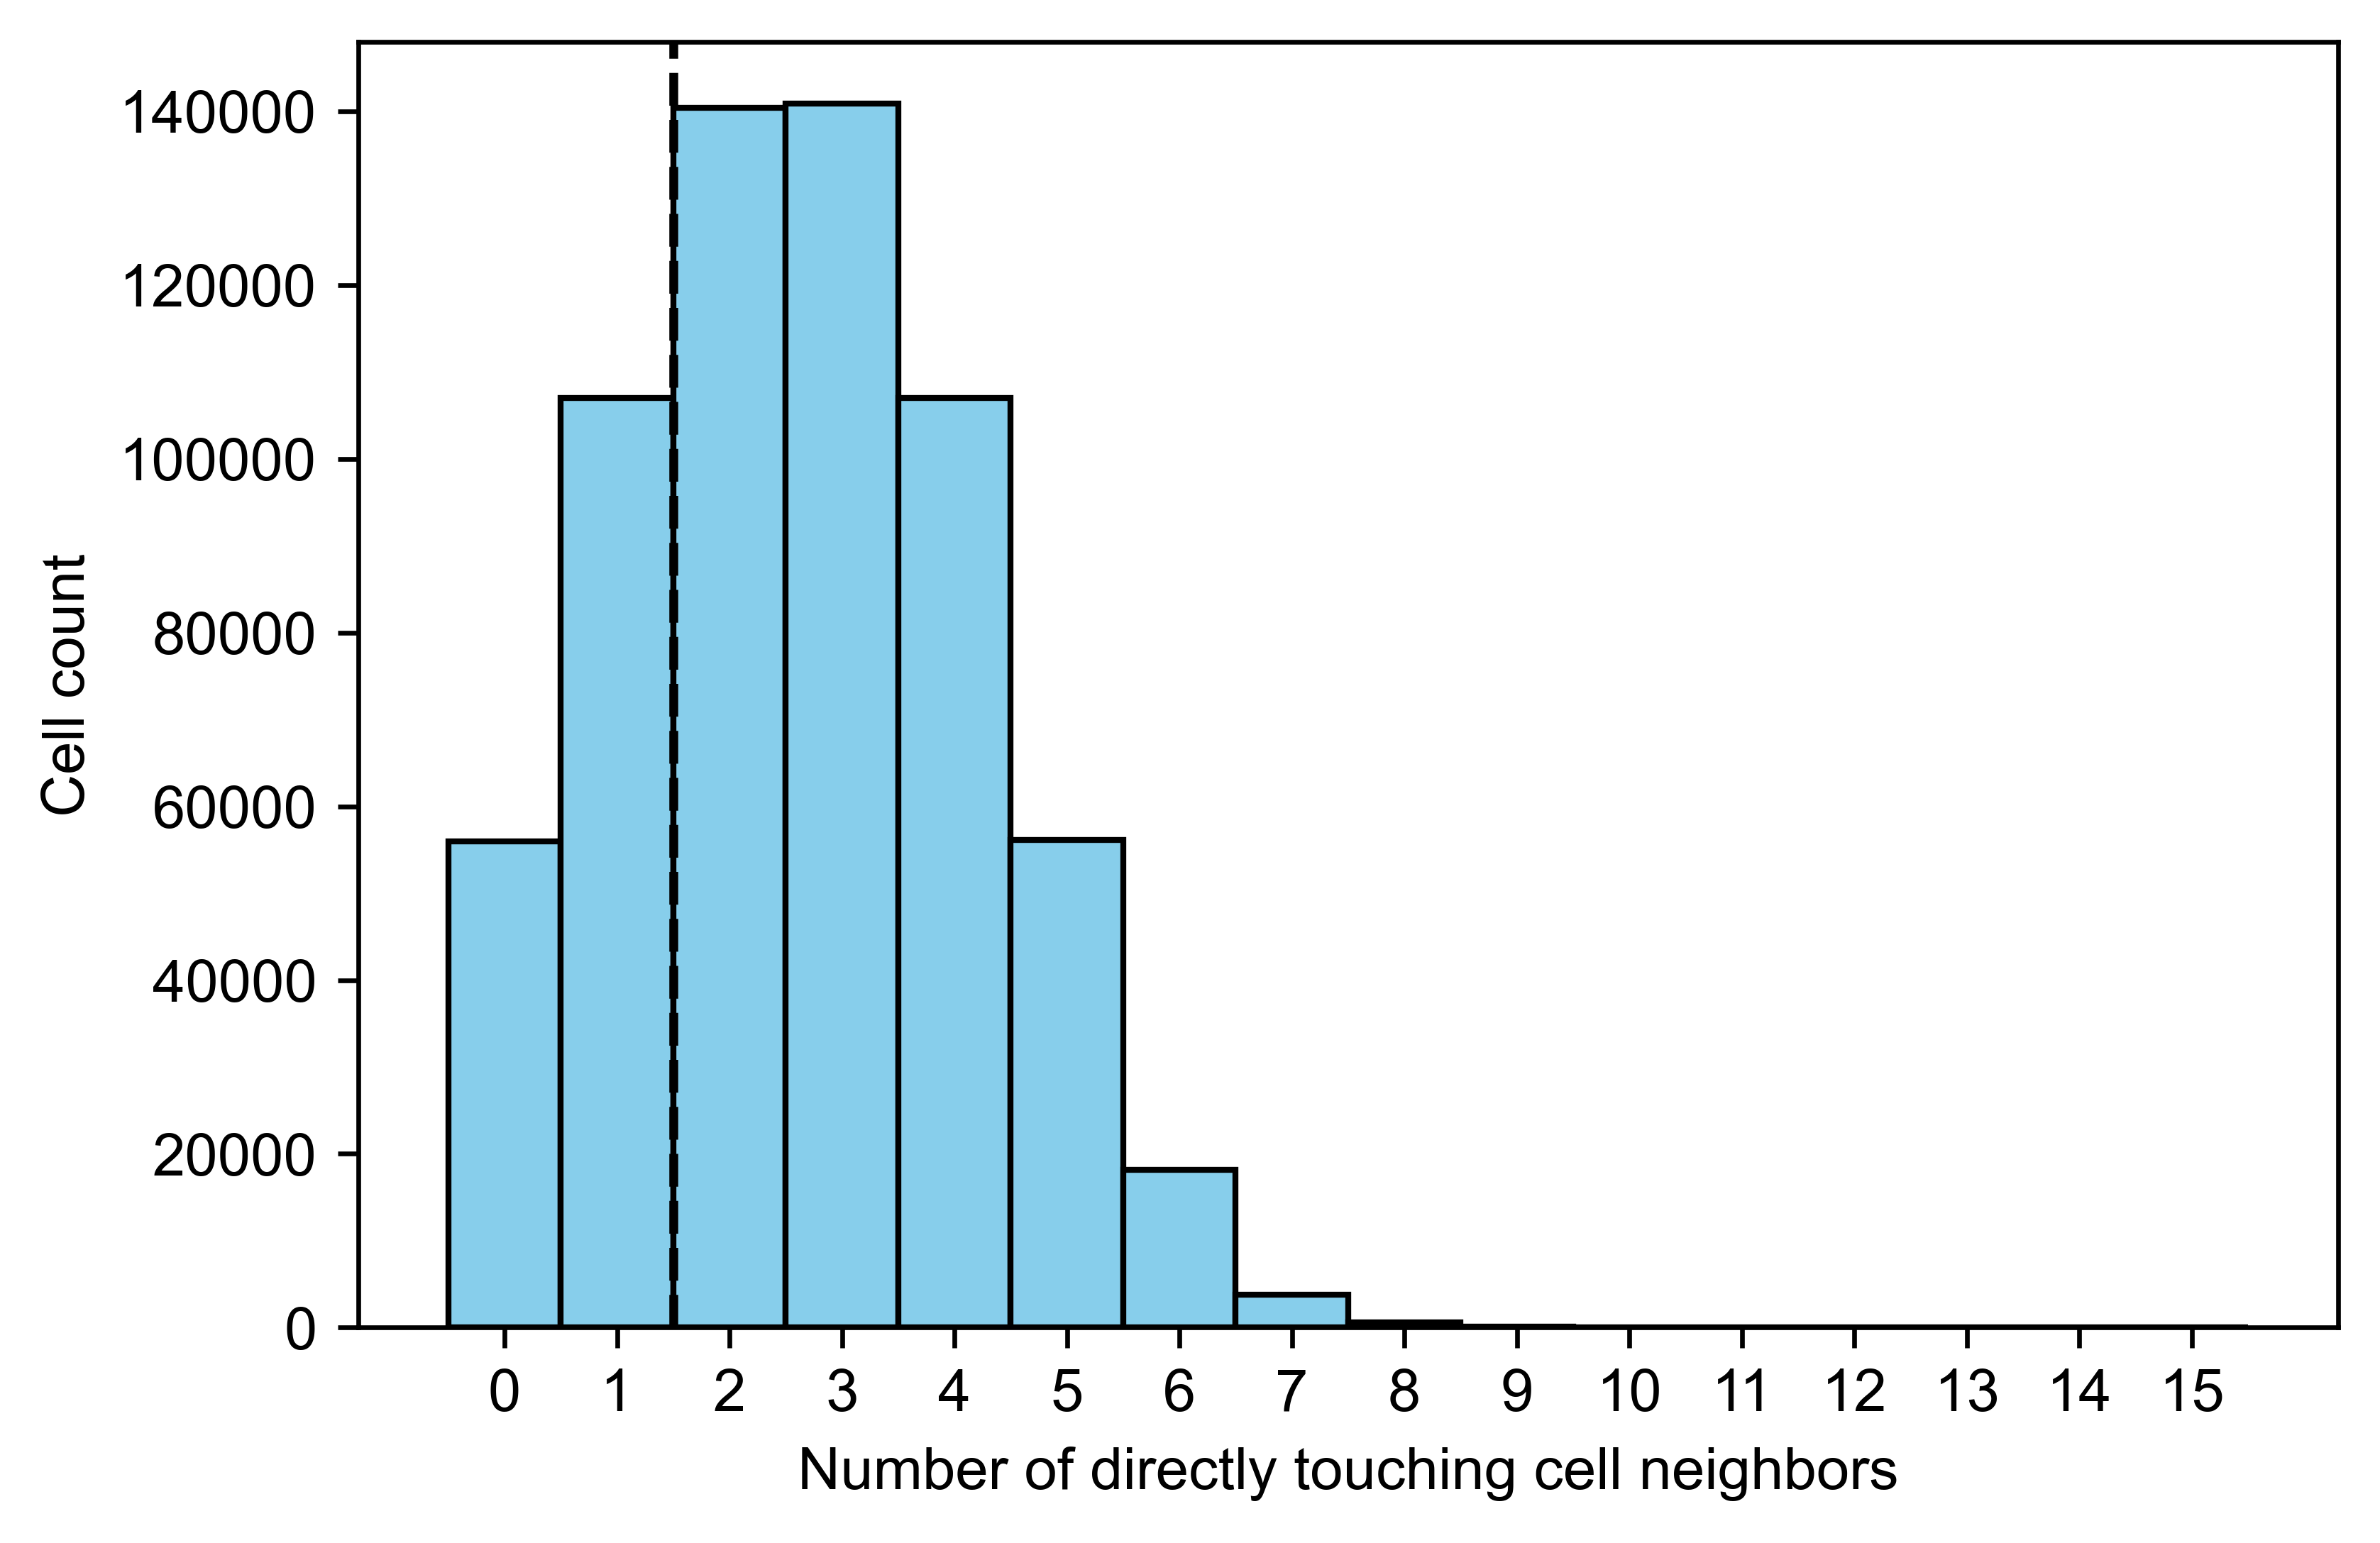

In [9]:
# covert dataframe column to numpy array
data = All_fovs_NN['num_touching'].to_numpy()

fig = plt.figure(dpi=600)
ax = fig.add_subplot(1,1,1)

# define bins
d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
bins = list(range(0, All_fovs_NN['num_touching'].max() + 1))

# create histogram
ax.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d), color = "skyblue", edgecolor = "black")
ax.xaxis.set_ticks(np.arange(0, 16, 1)) # specify x-axis ticks
ax.set_xlabel('Number of directly touching cell neighbors')
ax.set_ylabel('Cell count')
plt.axvline(x = 1.5, color = 'black', linestyle='dashed')
fig.savefig('cell_contacts_histogram.png', bbox_inches="tight")